# Movie Recommendations with Spark

[Recommender System](https://en.wikipedia.org/wiki/Recommender_system) is a system that predict ratings or preferences user may give to this item. It is a method to recommend things to people based on their past behaviour.We often sort or present as "top-N" recommendations which means recommendating people a set of N items from a large collection of items. 

In this project, we use [Apache Spark](https://spark.apache.org/) SparkMLib(ALS) and deep learning to build recommender systems which can provide recommendations to a user.

## Table of Contents

1. [Loading Data](#loading_data)
2. [Exploratory Data Analysis](#eda)
3. [Building Models](#building_model)
    - 3.1 [Pre-processing](#m_pre_processing)
    - 3.2 [Alternating Least Squares (ALS)](#als)
    - 3.3 [Depp Learning with Keras](#deep_learning)
4. [Summary](#summary)

In [1]:
pip install pyspark # dowload spark

     |████████████████████████████████| 212.4 MB 51 kB/s 
     |████████████████████████████████| 198 kB 55.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=98f758866d446f506b60859cffe0a13740a1dc713bb9e86fd2251dca72c46605
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StructType, IntegerType, StructField
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/movielens/movies.csv
/kaggle/input/movielens/ratings.csv
/kaggle/input/movielens/README.txt
/kaggle/input/movielens/tags.csv
/kaggle/input/movielens/links.csv


## 1. <a id='loading_data'></a>Loading Data¶

In [3]:
def load_moviename():
    movieNames = {}
    with open('../input/movielens/movies.csv', encoding='ISO-8859-1') as movies_file:
        next(movies_file)
        for row in movies_file:
            field = row.split(',')
            movieNames[int(field[0])] = field[1]
    return movieNames

spark = SparkSession.builder.appName('Movie_Recommendation').getOrCreate()
movies_dict = spark.sparkContext.broadcast(load_moviename())
data_rating = spark.read.option('header', 'true').option('inferschema', 'true').csv('../input/movielens/ratings.csv')
data_movies = spark.read.option('header', 'true').option('inferschema', 'true').csv('../input/movielens/movies.csv')

## 2. <a id='eda'></a>Exploratory Data Analysis

In [4]:
data_rating.columns

['userId', 'movieId', 'rating', 'timestamp']

In [5]:
data_movies.columns

['movieId', 'title', 'genres']

There are 4 columns in `rating.csv`, including `userId`,`movieId`, `rating`and `timestamp`, and 3 columns in `movies.csv`, including `movieId`, `title`, `genres`.

In [6]:
data_movie_split_genres = data_movies.withColumn('genres', func.explode(func.split('genres','[|]')))
data_movie_split_genres.select('genres').distinct().show()

+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



There are 20 genres in `movie.csv`.

In [7]:
data_rating.describe('rating').show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            100004|
|   mean| 3.543608255669773|
| stddev|1.0580641091070326|
|    min|               0.5|
|    max|               5.0|
+-------+------------------+



The minimum rating is 0.5 and maximum is 5.

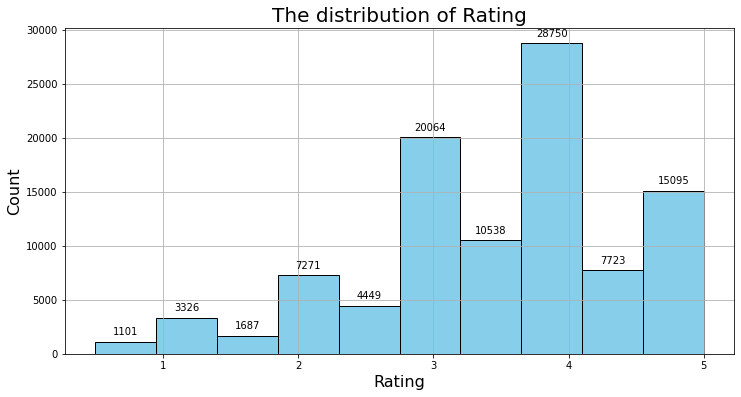

In [8]:
# plot the distribution of rating
data_rating_pandas = data_rating.select('rating').toPandas()
fig, ax = plt.subplots(figsize = (12, 6))
ax.hist(data_rating_pandas, color = "skyblue" , edgecolor='black', linewidth=1)

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

plt.title("The distribution of Rating", fontsize = 20)
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.grid()

In [9]:
# Extract top 20 popular films (based on the sum of rating)
top_movie = data_rating.groupBy('movieId').agg(func.sum('rating').alias('sum_rating'))\
                                          .sort('sum_rating', ascending=False)\
                                          .join(data_movies, 'movieId')\
                                          .select('movieId', 'title', 'genres')
print('Top 20 movies:')
top_movie.show(20, False)

Top 20 movies:
+-------+--------------------------------------------------+--------------------------------+
|movieId|title                                             |genres                          |
+-------+--------------------------------------------------+--------------------------------+
|1580   |Men in Black (a.k.a. MIB) (1997)                  |Action|Comedy|Sci-Fi            |
|2659   |It Came from Hollywood (1982)                     |Comedy|Documentary              |
|3794   |Chuck & Buck (2000)                               |Comedy|Drama                    |
|3175   |Galaxy Quest (1999)                               |Adventure|Comedy|Sci-Fi         |
|471    |Hudsucker Proxy, The (1994)                       |Comedy                          |
|1088   |Dirty Dancing (1987)                              |Drama|Musical|Romance           |
|1342   |Candyman (1992)                                   |Horror|Thriller                 |
|1645   |The Devil's Advocate (1997)         

## 3. <a id='building_model'></a>Building Models

### 3.1 <a id='m_pre_processing'></a>Pre-processing

In [10]:
# create label indexer for userId and movieId that maps a column of labels to a column of label indices.
print('Encoding userId and movieId....')
indexer_user = StringIndexer(inputCol='userId', outputCol='user_enco') 
indexed_user = indexer_user.fit(data_rating).transform(data_rating) 
indexer_movie = StringIndexer(inputCol='movieId', outputCol='movie_enco') 
data_indexed = indexer_movie.fit(indexed_user).transform(indexed_user)

# get the total number of user and movie in the datasets
num_users = int(data_indexed.select('user_enco').agg(func.max('user_enco')).collect()[0][0]) + 1
num_movies = int(data_indexed.select('movie_enco').agg(func.max('movie_enco')).collect()[0][0]) + 1

print('The total number of user is {}'.format(num_users))
print('The total number of movie is {}'.format(num_movies))

# normalize the rating
print('Normalize the rating....')
max_rating = 5
min_rating = 0.5

def scaled_rating(rating):
    return (rating - min_rating) / (max_rating - min_rating)

scaled_rating_udf = func.udf(scaled_rating)
df = data_indexed.withColumn('scaled_rating', scaled_rating_udf(func.col('rating')).cast('float'))

# create user encoding and movie encoding dataframe
user_encoder = df.select('userId', 'user_enco').distinct()
movie_encoder = df.select('movieId', 'movie_enco').distinct()

print('The dataframe as following...')
df.show(5, truncate=False)

Encoding userId and movieId....
The total number of user is 671
The total number of movie is 9066
Normalize the rating....
The dataframe as following...
+------+-------+------+----------+---------+----------+-------------+
|userId|movieId|rating|timestamp |user_enco|movie_enco|scaled_rating|
+------+-------+------+----------+---------+----------+-------------+
|1     |31     |2.5   |1260759144|643.0    |578.0     |0.44444445   |
|1     |1029   |3.0   |1260759179|643.0    |566.0     |0.5555556    |
|1     |1061   |3.0   |1260759182|643.0    |742.0     |0.5555556    |
|1     |1129   |2.0   |1260759185|643.0    |472.0     |0.33333334   |
|1     |1172   |4.0   |1260759205|643.0    |499.0     |0.7777778    |
+------+-------+------+----------+---------+----------+-------------+
only showing top 5 rows



In [11]:
# split the dataset into train and test set
train, test = df.randomSplit([0.8, 0.2], seed=1234)

### 3.2 <a id='als'></a>Alternating Least Squares (ALS)

In [12]:
# Extract top N list from ALS model
def recommendations_ALSmodel(user_id, num_rec, model):
    userSchema = StructType([StructField('userId', IntegerType(), True)])
    user = spark.createDataFrame([[user_id, ]], userSchema)
    recommendations = model.recommendForUserSubset(user, num_rec).collect()[0][1]
    result = spark.createDataFrame(recommendations)\
                  .join(data_movies, 'movieId')\
                  .select('title', 'genres')\
                  .take(num_rec)
    
    print('Showing the top {} recommendation for user: {}'.format(num_rec, user_id))
    print('===='*9)
    print('Movies wiht high ratings from user')
    print('----'*8)
    top_movie_user = df.filter(func.col('userId')==user_id)\
                       .join(data_movies, 'movieId')\
                       .sort('rating', ascending=False)\
                       .select('title', 'genres')\
                       .take(5)
    
    for row_top_movie_user in top_movie_user:
        print(row_top_movie_user[0], ":", row_top_movie_user[1])
        
    print('----'*8)
    print('The top {} movie recommendations'.format(num_rec))
    print('----'*8)
    for rec in result:
        print(rec[0], ":", rec[1])

In [13]:
for rank in range(8, 12):
    als = ALS(rank=rank, maxIter=5, regParam=0.01, userCol="userId", 
              itemCol="movieId", ratingCol="scaled_rating", coldStartStrategy="drop")
    als_model = als.fit(train)
    predictions = als_model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                    predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print('For rank {} the RMSE is {}'.format(rank, rmse))

For rank 8 the RMSE is 3.06118072325833
For rank 9 the RMSE is 3.064299773482194
For rank 10 the RMSE is 3.065322454574617
For rank 11 the RMSE is 3.0661689598418453


In [14]:
best_rank = 9
als = ALS(rank=best_rank, maxIter=5, regParam=0.01, userCol="userId", 
          itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
als_model = als.fit(train)

In [15]:
user_id = 474
num_rec = 10
recommendations_ALSmodel(user_id, num_rec, als_model)

Showing the top 10 recommendation for user: 474
Movies wiht high ratings from user
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Local Hero (1983) : Comedy
Singin' in the Rain (1952) : Comedy|Musical|Romance
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Godfather: Part II, The (1974) : Crime|Drama
--------------------------------
The top 10 movie recommendations
--------------------------------
Freeway (1996) : Comedy|Crime|Drama|Thriller
Emperor's New Groove, The (2000) : Adventure|Animation|Children|Comedy|Fantasy
Dogville (2003) : Drama|Mystery|Thriller
Naked (1993) : Drama
Angels in the Outfield (1994) : Children|Comedy
Cooler, The (2003) : Comedy|Drama|Romance
Twin Peaks: Fire Walk with Me (1992) : Crime|Drama|Mystery|Thriller
City of Angels (1998) : Drama|Fantasy|Romance
Children of Paradise (Les enfants du paradis) (1945) : Drama|Romance
Hocus Pocus (1993) : Children|Comedy|Fantasy|Horror


### 3.3 <a id='deep_learning'></a>Depp Learning with Keras

In [16]:
# Extract top N list from Deep Learning model
def recommendations_DLmodel(user_id, num_rec, model):
    watched_movie = np.array(df.filter(func.col('userId') == user_id).select('movieId').collect())
    
    movies_not_watched = []
    for id, title in movies_dict.value.items():
        if id not in watched_movie:
            movies_not_watched.append(id)
            
    user = [user_id] * len(movies_not_watched)

    pred_user_movie = spark.createDataFrame(
        zip(user, movies_not_watched), ['userId', 'movieId']
    )
    
    pred_user_movie = pred_user_movie.join(user_encoder, 'userId').join(movie_encoder, 'movieId')
    
    pred = np.array(pred_user_movie.select('user_enco','movie_enco').collect())
    pred_rating = model.predict(pred).flatten()
    
    predition = spark.createDataFrame(zip(pred[:,1].tolist(), pred_rating.tolist()), ['movie_enco', 'pre_scaled_rating'])
    

    result = pred_user_movie.join(predition, 'movie_enco')\
                            .withColumn('pred_rating', func.round(func.col('pre_scaled_rating')*(max_rating - min_rating)+ min_rating, 2))\
                            .sort('pred_rating', ascending=False)\
                            .join(data_movies, 'movieId')\
                            .select('title', 'genres')\
                            .take(num_rec)
    
    print('Showing the top {} recommendation for user: {}'.format(num_rec, user_id))
    print('===='*9)
    print('Movies wiht high ratings from user')
    print('----'*8)
    top_movie_user = df.filter(func.col('userId')==user_id)\
                       .join(data_movies, 'movieId')\
                       .sort('rating', ascending=False)\
                       .select('title', 'genres')\
                       .take(5)
    
    for row_top_movie_user in top_movie_user:
        print(row_top_movie_user[0], ":", row_top_movie_user[1])
        
    print('----'*8)
    print('The top {} movie recommendations'.format(num_rec))
    print('----'*8)
    for rec in result:
        print(rec[0], ":", rec[1])

In [17]:
X_train = np.array(train.select('user_enco','movie_enco').collect())
X_test = np.array(test.select('user_enco','movie_enco').collect())
y_train = np.array(train.select('scaled_rating').collect())
y_test = np.array(test.select('scaled_rating').collect())

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80149, 2), (19855, 2), (80149, 1), (19855, 1))

In [18]:
# construct deep learning model
EMBEDDING_SIZE = 50
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_movies, embedding_size, latent_dim=10, intermediate_dim=32, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(
            num_users+1,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.movie_embedding = layers.Embedding(
            num_movies+1,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )

        self.user_flatten = layers.Flatten()
        
        self.movie_flatten = layers.Flatten()
        
        self.dense_1 = layers.Dense(
            intermediate_dim, activation = 'relu'
        )
        self.dense_2 = layers.Dense(
            latent_dim, activation = 'relu'
        )
        
    def call(self, inputs):
        user_embedding = self.user_embedding(inputs[:, 0])
        movie_embedding = self.movie_embedding(inputs[:, 1])
        user_flatten = self.user_flatten(user_embedding)
        movie_flatten = self.movie_flatten(movie_embedding)
        user_movie_concatenate = layers.concatenate([user_flatten, movie_flatten])
        dense_layer_1 = self.dense_1(user_movie_concatenate)
        dense_layer_2 = self.dense_2(dense_layer_1)
        out_put = tf.nn.sigmoid(dense_layer_2)
        return out_put

In [19]:
dl_model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
opt = Adam(lr=0.001)
dl_model.compile(loss='mean_squared_error', optimizer=opt)

In [20]:
history = dl_model.fit(x=X_train, y=y_train, batch_size=64, epochs=10, 
                       verbose=1, validation_data=(X_test , y_test))

Epoch 1/10
1253/1253 [==============================] - 6s 4ms/step - loss: 0.0529 - val_loss: 0.0408
Epoch 2/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0377 - val_loss: 0.0407
Epoch 3/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0366 - val_loss: 0.0408
Epoch 4/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0352 - val_loss: 0.0411
Epoch 5/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0348 - val_loss: 0.0411
Epoch 6/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0341 - val_loss: 0.0416
Epoch 7/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0331 - val_loss: 0.0420
Epoch 8/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0323 - val_loss: 0.0427
Epoch 9/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.0313 - val_loss: 0.0431
Epoch 10/10
1253/1253 [==============================] - 5s 4ms/step - loss: 0.030

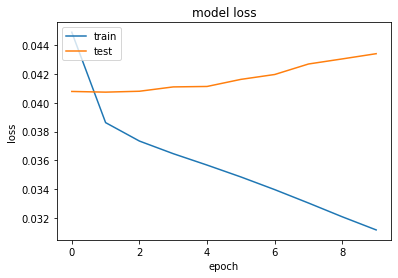

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [22]:
user_id = 474
num_rec = 10
recommendations_DLmodel(user_id, num_rec, dl_model)

Showing the top 10 recommendation for user: 474
Movies wiht high ratings from user
--------------------------------
Philadelphia Story, The (1940) : Comedy|Drama|Romance
Local Hero (1983) : Comedy
Singin' in the Rain (1952) : Comedy|Musical|Romance
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Godfather: Part II, The (1974) : Crime|Drama
--------------------------------
The top 10 movie recommendations
--------------------------------
Patriot, The (2000) : Action|Drama|War
Exorcist, The (1973) : Horror|Mystery
Charlie and the Chocolate Factory (2005) : Adventure|Children|Comedy|Fantasy|IMAX
Double Jeopardy (1999) : Action|Crime|Drama|Thriller
Rebel Without a Cause (1955) : Drama
Ghost World (2001) : Comedy|Drama
Scream 2 (1997) : Comedy|Horror|Mystery|Thriller
Hoosiers (a.k.a. Best Shot) (1986) : Drama|Romance
Munich (2005) : Action|Crime|Drama|Thriller
Man with Two Brains, The (1983) : Comedy


## 4. <a id='summary'></a>Summary

For the userID 474, different algorithms provide different recommendations.

|Movies with high ratings from user |
|:------------------------------   |
|Philadelphia Story, The (1940) : Comedy,Drama,Romance <br> Local Hero (1983) : Comedy <br> Singin' in the Rain (1952) : Comedy,Musical,Romance <br> Princess Bride, The (1987) : Action,Adventure,Comedy,Fantasy,Romance <br> Godfather: Part II, The (1974) : Crime,Drama|

|Algorithm  |Recommendations   |Algorithm  |Recommendations   |
|  :----:   |:----             |  :----:   |:----             |
|ALS        | Baraka (1992) : Documentary <br> Dear Zachary: A Letter to a Son About His Father (2008) : Documentary <br> Benji (1974) : Adventure,Children <br> Education, An (2009) : Drama,Romance <br> It's a Mad, Mad, Mad, Mad World (1963) : Action,Adventure,Comedy,Crime <br> Fountain, The (2006) : Drama,Fantasy,Romance <br> Frozen (2013) : Adventure,Animation,Comedy,Fantasy,Musical,Romance <br> Wings of Desire (Himmel über Berlin, Der) (1987) : Drama,Fantasy,Romance <br> Big Easy, The (1987) : Action,Crime,Mystery,Romance,Thriller <br> Hedwig and the Angry Inch (2000) : Comedy,Drama,Musical |deep learning  |Patriot, The (2000) : Action,Drama,War <br> Exorcist, The (1973) : Horror,Mystery <br> Charlie and the Chocolate Factory (2005) : Adventure,Children,Comedy,Fantasy,IMAX <br> Double Jeopardy (1999) : Action,Crime,Drama,Thriller <br> Rebel Without a Cause (1955) : Drama <br> Ghost World (2001) : Comedy,Drama <br> Scream 2 (1997) : Comedy,Horror,Mystery,Thriller <br> Hoosiers (a.k.a. Best Shot) (1986) : Drama,Romance <br> Munich (2005) : Action,Crime,Drama,Thriller <br> Man with Two Brains, The (1983) : Comedy |
